# Initial model training

Importing relevant libraries

In [1]:
import numpy as np
import math
import pandas as pd
import pandas_profiling
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
#Keras modules
from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model
import keras_metrics

Using TensorFlow backend.


In [3]:
#Function to create a confusion matrix
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes =unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    plt.grid(b=None)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
  
    return ax

In [5]:
#Functino to select relevant fields from the csv files
def selectFields(df):
    new = df.filter(['ada_score','AF','BLOSUM62','codon_degeneracy','Eigen-pred_coding','GERP++_RS', 
              'integrated_fitCons_score','LoFtool','phyloP100way_vertebrate','SIFT','Consequence'])
    return new

In [7]:
#Function to replace empty values
def fillEmpty(df):
    df = df.replace({'ada_score': "-", 'AF': "-", 'Eigen-pred_coding': '-',
               'integrated_fitCons_score': '-', 'LoFtool': '-', 'phyloP100way_vertebrate':'-',
               'SIFT': '-'}, -1)
    df = df.replace({'BLOSUM62':"-", 'GERP++_RS':'-'}, 0)
    return df

In [10]:
#Function to split codon degeneracy field
def splitCodonDeg (df):
    df['codon_degeneracy'] = df['codon_degeneracy'].str.split(',').str[0]
    df['Consequence'] = df['Consequence'].str.split(',').str[0]
    df = df.replace({'codon_degeneracy':'-'},0)
    return df
                

In [4]:
# Importing datasets
ben = pd.read_csv('BEN_2020.txt', sep='\t')
pat = pd.read_csv('PAT_2020.txt', sep='\t')
vus = pd.read_csv('VUS_2020.txt', sep='\t')
ben_exvus = pd.read_csv('EXVUS_BEN_2020.txt', sep='\t')
pat_exvus = pd.read_csv('EXVUS_PAT_2020.txt', sep='\t')

In [6]:
# Processing datasets
ben_fields = selectFields(ben)
pat_fields = selectFields(pat)
vus_fields = selectFields(vus)
ben_ex_fields = selectFields(ben_exvus)
pat_ex_fields = selectFields(pat_exvus)
ben_full = fillEmpty( ben_fields)
pat_full = fillEmpty( pat_fields )
vus_full = fillEmpty( vus_fields )
ben_ex_full = fillEmpty (ben_ex_fields)
pat_ex_full = fillEmpty (pat_ex_fields)
ben_ok = ben_ok.sample(n=pat_rows, random_state=2)
ben_ok = splitCodonDeg (ben_full)
pat_ok = splitCodonDeg (pat_full)
vus_ok = splitCodonDeg (vus_full)
ben_ex_ok = splitCodonDeg (ben_ex_full)
pat_ex_ok = splitCodonDeg (pat_ex_full)
ben_ok['CLINSIG']=0
pat_ok['CLINSIG']=1
set_ok = pd.concat([ben_ok, pat_ok])
ben_ex_ok['CLINSIG']=0
pat_ex_ok['CLINSIG']=1
set_ex_ok= pd.concat([ben_ex_ok,pat_ex_ok])
set_dummies=pd.get_dummies(set_ok,columns=['Consequence'])
set_ex_dummies=pd.get_dummies(set_ex_ok,columns=['Consequence'])
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(set_dummies)
scaler.fit(set_ex_dummies)
set_float = set_dummies.astype(float)
set_ex_float = set_ex_dummies.astype(float)

In [15]:
#Creation of initial training and testing sets
X = set_float.drop(['CLINSIG'],axis=1)
y=set_float['CLINSIG']
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_test.to_csv(r'X_test.csv',index=False)
y_test.to_csv(r'y_test.csv',index=False)

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96      5031
         1.0       0.94      0.98      0.96      5001

    accuracy                           0.96     10032
   macro avg       0.96      0.96      0.96     10032
weighted avg       0.96      0.96      0.96     10032

Normalized confusion matrix
Confusion matrix, without normalization


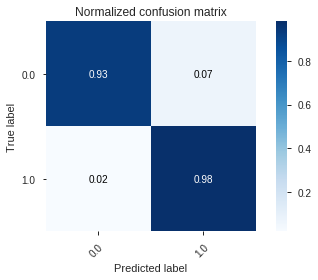

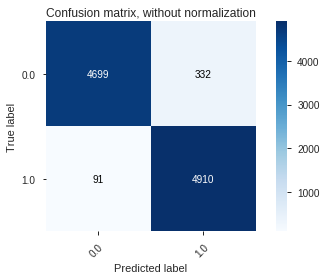

In [16]:
#Training Random Forest model
rfc=RandomForestClassifier(random_state=2, class_weight = "balanced", n_jobs=3)
param_grid = { 
    'n_estimators': [128,256,512,1024],
    'max_depth' : [4,7,10,15],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, scoring='roc_auc')
CV_rfc.fit(X_train, y_train)
rf_bests=CV_rfc.best_params_
clf_RF = RandomForestClassifier(n_jobs=3,n_estimators=rf_bests['n_estimators'], 
                                max_depth=rf_bests['max_depth'], 
                                class_weight="balanced",
                                random_state=2, 
                                criterion=rf_bests['criterion'])
modelo=clf_RF.fit(X_train,y_train)
prediction_RF=clf_RF.predict(X_test)
print(classification_report(y_test,prediction_RF))
plot_confusion_matrix(y_test, prediction_RF.astype(int), True)
plot_confusion_matrix(y_test, prediction_RF.astype(int), False)

In [16]:
#Feature importances from the RF Model
importances = pd.DataFrame(clf_RF.feature_importances_, index=X_train.columns)
importances = importances.sort_values(by=[0])
importances

,0
Consequence_TF_binding_site_variant,0.000009
Consequence_protein_altering_variant,0.000015
Consequence_stop_lost,0.000015
Consequence_stop_retained_variant,0.000024
Consequence_inframe_insertion,0.000330
Consequence_3_prime_UTR_variant,0.000333
Consequence_start_lost,0.000506
Consequence_inframe_deletion,0.000604
Consequence_downstream_gene_variant,0.000684
Consequence_5_prime_UTR_variant,0.000982


              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      5031
         1.0       0.90      0.97      0.93      5001

    accuracy                           0.93     10032
   macro avg       0.93      0.93      0.93     10032
weighted avg       0.93      0.93      0.93     10032

Normalized confusion matrix
Confusion matrix, without normalization


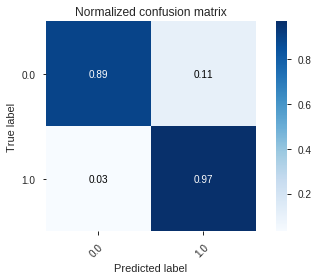

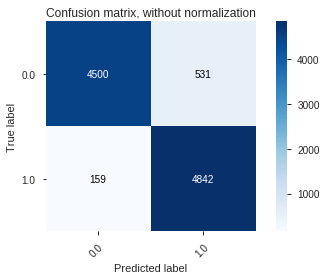

In [19]:
#Training SVM model

svm_modelo = svm.SVC(probability=True)
param_grid = { 
    'C': [0.1,1,10],
    'gamma' : [0.01,0.1,1],
    'kernel' :['rbf']
}
CV_svm = GridSearchCV(estimator=svm_modelo, param_grid=param_grid, cv= 3, scoring='roc_auc')
CV_svm.fit(X_train, y_train)
best_svm=CV_svm.best_params_
svm_modelo = svm.SVC(probability = True, C=best_svm['C'], gamma=best_svm['gamma'],kernel=best_svm['kernel'])
svm_modelo.fit(X_train,y_train)
prediction_svm=svm_modelo.predict(X_test)
print(classification_report(y_test,prediction_svm))
plot_confusion_matrix(y_test, prediction_svm.astype(int), True)
plot_confusion_matrix(y_test, prediction_svm.astype(int), False)

In [18]:
# Function to create MLP

def perceptron_multi(X,y):
    perceptron_multicapa = Sequential()
    perceptron_multicapa.add(Dense(20, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    perceptron_multicapa.add(Dense(10, input_dim=X.shape[1], activation='relu'))
    #perceptron_multicapa.add(Dense(10, activation='relu'))
    perceptron_multicapa.add(Dense(1, activation='sigmoid'))
    perceptron_multicapa.compile(optimizer='adam',
                                 loss='binary_crossentropy',
                                 metrics=['accuracy', keras_metrics.recall()]
                                )
    perceptron_multicapa.fit(X, y, epochs=25, batch_size=50)
    return perceptron_multicapa

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn
Epoch 1/25
40128/40128 [==============================] - 3s 71us/step - loss: 0.2275 - accuracy: 0.8988 - recall: 0.9317
Epoch 2/25
40128/40128 [==============================] - 2s 46us/step - loss: 0.1379 - accuracy: 0.9443 - recall: 0.9594
Epoch 3/25
40128/40128 [==============================] - 2s 48us/step - loss: 0.1340 - accuracy: 0.9455 - recall: 0.9644
Epoch 4/25
40128/40128 [==============================] - 2s 47us/step - loss: 0.1325 - accuracy: 0.9457 - recall: 0.9623
Epoch 5/25
40128/40128 [==============================] - 2s 49us/step - loss: 0.1312 - accuracy: 0.9466 - recall: 0.9624
Epoch 6/25
40128/40128 [==============================] - 2s 48us/step - loss: 0.1302 - accuracy: 0.9464 - recall: 0.9639
Epoch 7/25
40128/40128 [==============================] - 2s 47us/step - loss: 0.1299 - accuracy: 0.9469 - recall: 0.9634
Epoch 8/

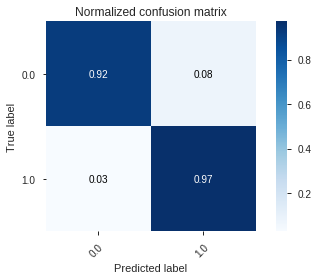

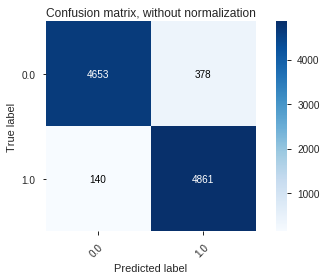

In [19]:
#Training MLP model
red_modelo = perceptron_multi(X_train, y_train.astype(float))
plot_confusion_matrix(y_test, red_modelo.predict_classes(X_test).astype(int), True)
plot_confusion_matrix(y_test, red_modelo.predict_classes(X_test).astype(int), False)

In [27]:
#Model ROCs

score_RF=clf_RF.predict_proba(X_test)
score_RF
fpr_RF, tpr_RF, threshs = metrics.roc_curve(y_test,score_RF[:,1])
roc_auc_RF= auc(fpr_RF, tpr_RF)

score_SVM=svm_modelo.predict_proba(X_test)
score_SVM
fpr_SVM, tpr_SVM, threshs = metrics.roc_curve(y_test,score_SVM[:,1])
roc_auc_SVM= auc(fpr_SVM, tpr_SVM)

red_probas = red_modelo.predict_proba(X_test)
fpr_MLP, tpr_MLP, threshs = metrics.roc_curve(y_test, red_probas)
roc_auc_mlp= auc(fpr_MLP, tpr_MLP)

fpr_CADD, tpr_CADD, threshs= metrics.roc_curve(y_test,X_test['CADD_PHRED'])
roc_auc_CADD= auc(fpr_CADD, tpr_CADD)
plt.close('all')

plt.figure(figsize=(15, 12))
lw = 2

plt.plot(fpr_RF,tpr_RF,
         lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF)
plt.plot(fpr_SVM,tpr_SVM, 
         lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM)
plt.plot(fpr_MLP, tpr_MLP, 
         lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp)
plt.plot(fpr_dt, tpr_dt, 
        lw=5, label='Decision Tree (area = %0.2f)' % roc_auc_dt)
plt.plot(fpr_nb, tpr_nb, 
        lw=5, label='Naive Bayes(area = %0.2f)' % roc_auc_nb)
plt.plot(fpr_CADD, tpr_CADD,
         lw=lw, label='CADD (area = %0.2f)' % roc_auc_CADD)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('ROCs - Pathogenicity Prediction VUS - All Variant Types',fontsize=30)
plt.legend(fontsize=22,loc='center left', bbox_to_anchor=(1, 0.5),framealpha=1,frameon=1)

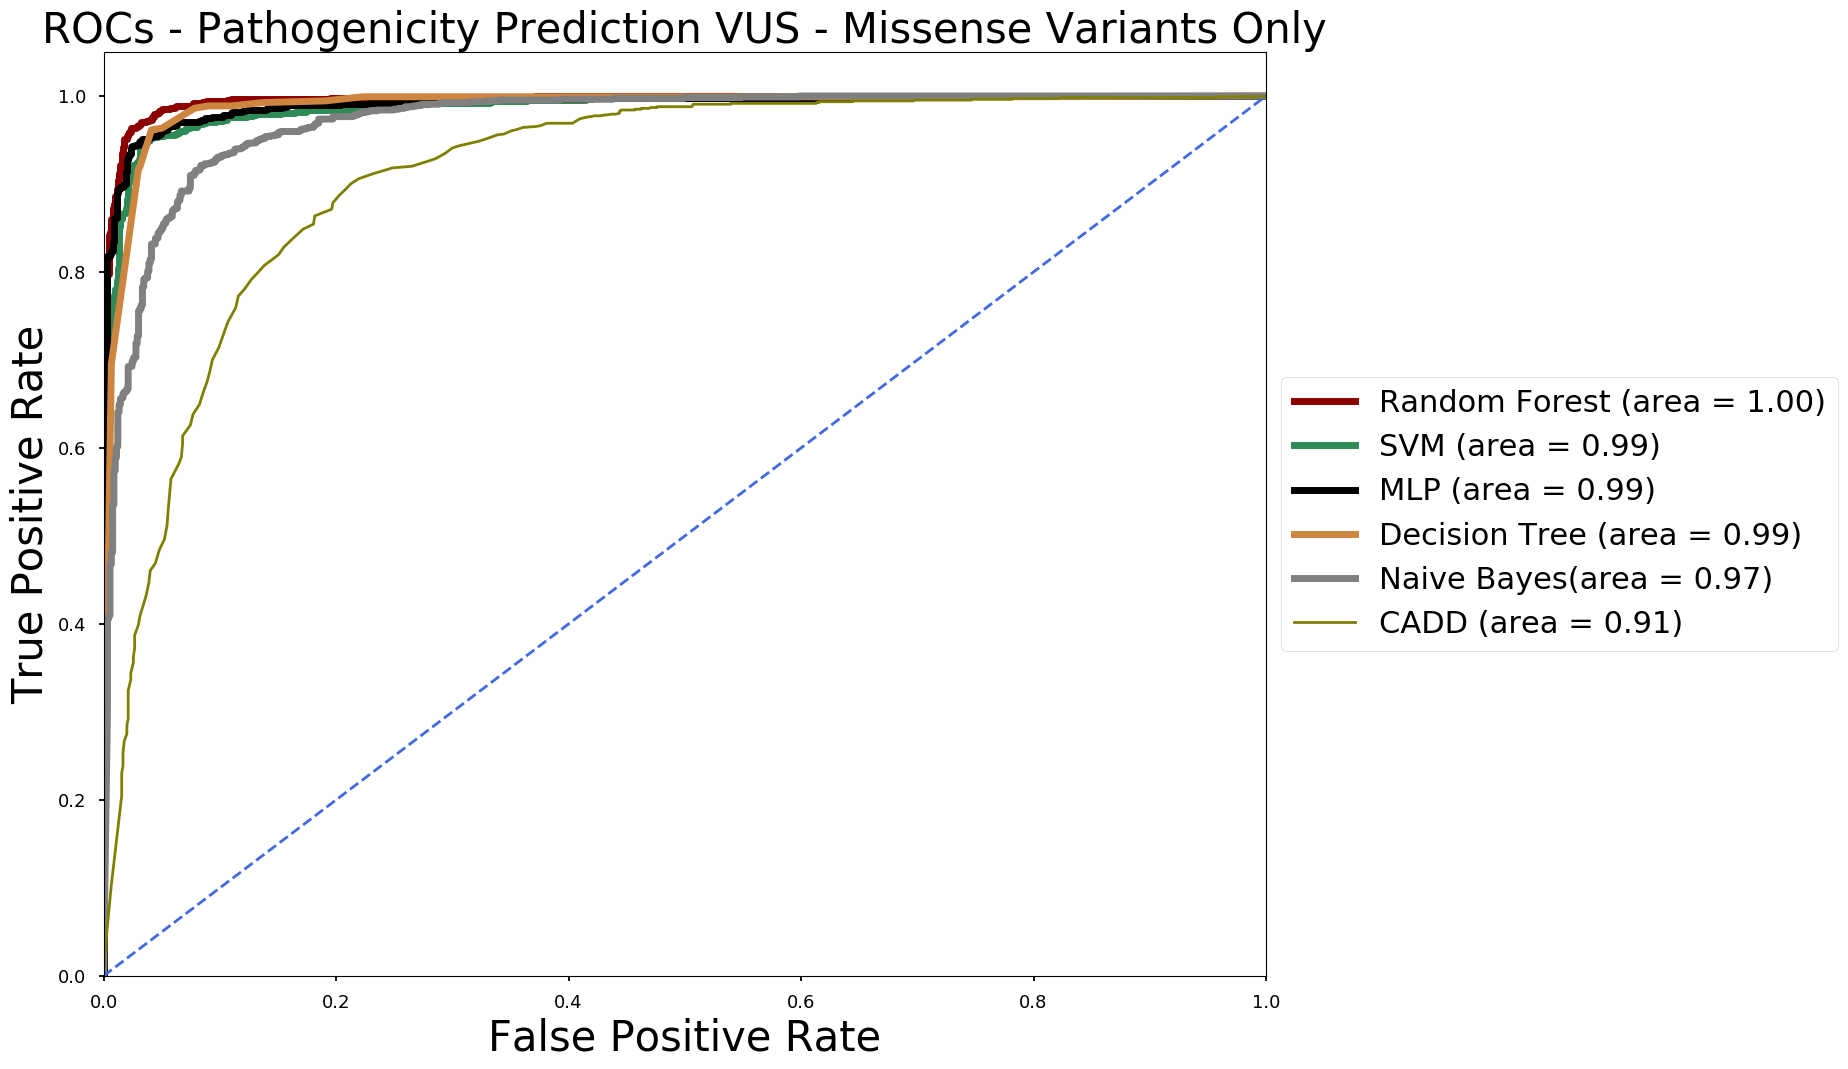

In [403]:
#Model ROCs - "missense" variants only

both = X_test
both['CLINSIG']=y_test
both_miss = both[both['Consequence_missense_variant']==1]
X_miss = both_miss.drop(['CLINSIG'],axis=1)
y_miss = both_miss['CLINSIG']
score_nb_miss=clf_nb.predict_proba(X_miss)
score_nb_miss
fpr_nb_miss, tpr_nb_miss, threshs = metrics.roc_curve(y_miss,score_nb_miss[:,1])
roc_auc_nb_miss= auc(fpr_nb_miss, tpr_nb_miss)

score_dt_miss=clf_dt.predict_proba(X_miss)
score_dt_miss
fpr_dt_miss, tpr_dt_miss, threshs = metrics.roc_curve(y_miss,score_dt_miss[:,1])
roc_auc_dt_miss= auc(fpr_dt_miss, tpr_dt_miss)

score_RF_miss=clf_RF.predict_proba(X_miss)
score_RF_miss
fpr_RF_miss, tpr_RF_miss, threshs = metrics.roc_curve(y_miss,score_RF_miss[:,1])
roc_auc_RF_miss= auc(fpr_RF_miss, tpr_RF_miss)

score_SVM_miss=svm_modelo.predict_proba(X_miss)
score_SVM_miss
fpr_SVM_miss, tpr_SVM_miss, threshs = metrics.roc_curve(y_miss,score_SVM_miss[:,1])
roc_auc_SVM_miss= auc(fpr_SVM_miss, tpr_SVM_miss)

red_probas_miss = red_modelo.predict_proba(X_miss)
fpr_MLP_miss, tpr_MLP_miss, thresholds = metrics.roc_curve(y_miss, red_probas_miss)
roc_auc_mlp_miss= auc(fpr_MLP_miss, tpr_MLP_miss)

fpr_CADD_miss, tpr_CADD_miss, threshs= metrics.roc_curve(y_miss,X_miss['CADD_PHRED'])
roc_auc_CADD_miss= auc(fpr_CADD_miss, tpr_CADD_miss)

plt.close('all')

plt.figure(figsize=(15, 12))
lw = 2

plt.plot(fpr_RF_miss,tpr_RF_miss, color='darkred',
         lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF_miss)
plt.plot(fpr_SVM_miss,tpr_SVM_miss, color='seagreen',
         lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM_miss)
plt.plot(fpr_MLP_miss, tpr_MLP_miss, color='black',
         lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp_miss)
plt.plot(fpr_dt_miss, tpr_dt_miss, color='peru', 
        lw=5, label='Decision Tree (area = %0.2f)' % roc_auc_dt_miss)
plt.plot(fpr_nb_miss, tpr_nb_miss, color='gray', 
        lw=5, label='Naive Bayes(area = %0.2f)' % roc_auc_nb_miss)
plt.plot(fpr_CADD_miss, tpr_CADD_miss, color='olive',
         lw=lw, label='CADD (area = %0.2f)' % roc_auc_CADD_miss)
plt.plot([0, 1], [0, 1], color='royalblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=30)
plt.ylabel('True Positive Rate',fontsize=30)
plt.title('ROCs - Pathogenicity Prediction VUS - Missense Variants Only',fontsize=30)
plt.legend(fontsize=22,loc='center left', bbox_to_anchor=(1, 0.5),framealpha=1,frameon=1)

# Benchmarking with the ex VUS set

In [20]:
#Function to replace all empty fields
def fillAll(df):
    df = df.replace("-",0)
    df = df.replace(".",0)
    return df

In [21]:
#Function to complete columns from the exVUS set
def completeColumns (df):
    consequences = ['Consequence_3_prime_UTR_variant',
       'Consequence_5_prime_UTR_variant',
       'Consequence_TF_binding_site_variant',
       'Consequence_downstream_gene_variant', 'Consequence_frameshift_variant',
       'Consequence_inframe_deletion', 'Consequence_inframe_insertion',
       'Consequence_intergenic_variant', 'Consequence_intron_variant',
       'Consequence_missense_variant',
       'Consequence_non_coding_transcript_exon_variant',
       'Consequence_protein_altering_variant',
       'Consequence_regulatory_region_variant',
       'Consequence_splice_acceptor_variant',
       'Consequence_splice_donor_variant', 'Consequence_splice_region_variant',
       'Consequence_start_lost', 'Consequence_stop_gained',
       'Consequence_stop_lost', 'Consequence_stop_retained_variant',
       'Consequence_synonymous_variant', 'Consequence_upstream_gene_variant']
    for c in consequences:
        try:
            df[c]
        except:
            df[c] = 0
        
    return df

In [22]:
#Process ex VUS sets
ben_ex = ben_exvus
pat_ex = pat_exvus
ben_ex['CLINSIG'] = 0
pat_ex['CLINSIG'] = 1
set_ex_all = pd.concat([ben_ex, pat_ex])
set_ex_all_filter = selectFields (set_ex_all)
set_ex_all_fill = fillEmpty(set_ex_all_filter)
set_ex_all_split = splitCodonDeg (set_ex_all_fill)
set_ex_all_dummies =pd.get_dummies(set_ex_all_split,columns=['Consequence'])
set_ex_all_complete = completeColumns(set_ex_all_dummies) 
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
scaler.fit(set_ex_all_complete)
X_ex = set_ex_all_complete.astype(float) 
y_ex = set_ex_all['CLINSIG']

set_ex_all_tools=set_ex_all.filter(['DANN_score','Eigen-pred_coding','LRT_score','M-CAP_score',
                                          'MetaLR_score','MetaSVM_score',
                                          'MutPred_score','PolyPhen','REVEL_score','SIFT',
                                          'ada_score', 'rf_score', 'CADD_PHRED'])
set_ex_all_filled=fillAll(set_ex_all_tools)
tools_scores = set_ex_all_filled.astype(float)

In [24]:
#Function to create ROCS from scores
def carlROC(column):
    fpr, tpr, threshs= metrics.roc_curve(y_ex,tools_scores[column])
    roc_auc= auc(fpr, tpr)
    values = {'roc_auc': roc_auc, 'fpr': fpr, 'tpr': tpr}
    return values

In [25]:
# Creation of ROC values from scores
values_DANN= carlROC('DANN_score')
values_Eigen= carlROC('Eigen-pred_coding')
values_LRT= carlROC('LRT_score')
values_MCAP= carlROC('M-CAP_score')
values_MetaLR= carlROC('MetaLR_score')
values_MetaSVM= carlROC('MetaSVM_score')
values_MutPred= carlROC('MutPred_score')
values_PolyPhen= carlROC('PolyPhen')
values_Revel= carlROC('REVEL_score')
values_Sift= carlROC('SIFT')
values_ada= carlROC('ada_score')
values_rf= carlROC('rf_score')
values_CADD= carlROC('CADD_PHRED')

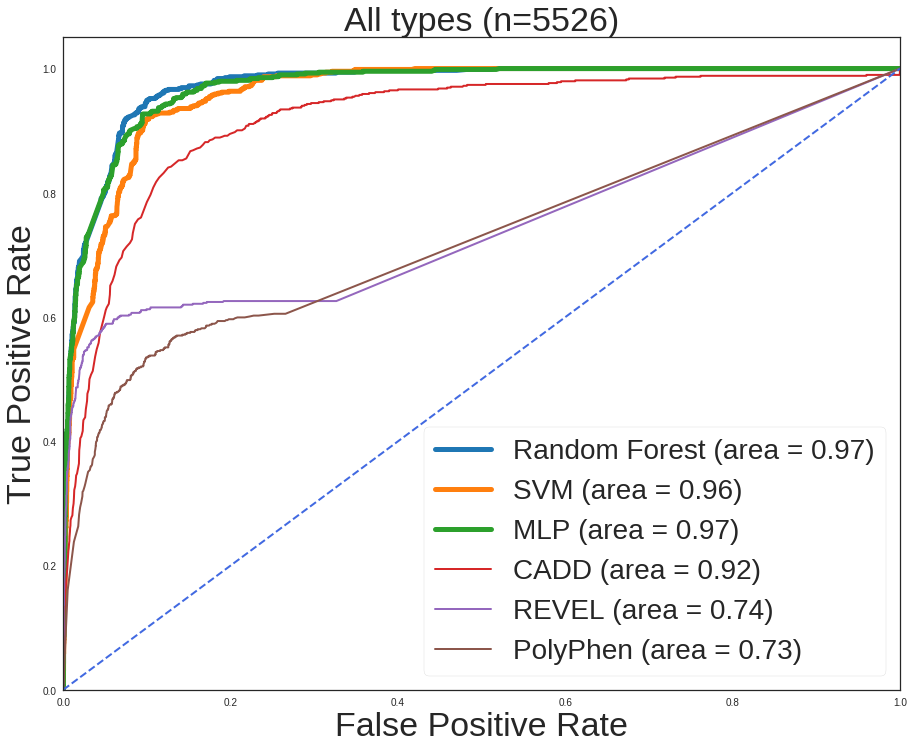

In [111]:
# Creation of ROC plots 
score_RF_ex=clf_RF.predict_proba(X_ex)
score_RF_ex
fpr_RF_ex, tpr_RF_ex, threshs = metrics.roc_curve(y_ex,score_RF_ex[:,1])
roc_auc_RF_ex= auc(fpr_RF_ex, tpr_RF_ex)

score_SVM_ex=svm_modelo.predict_proba(X_ex)
score_SVM_ex
fpr_SVM_ex, tpr_SVM_ex, threshs = metrics.roc_curve(y_ex,score_SVM_ex[:,1])
roc_auc_SVM_ex= auc(fpr_SVM_ex, tpr_SVM_ex)

red_probas_ex = red_modelo.predict_proba(X_ex)
fpr_MLP_ex, tpr_MLP_ex, thresholds = metrics.roc_curve(y_ex, red_probas_ex)
roc_auc_mlp_ex= auc(fpr_MLP_ex, tpr_MLP_ex)
plt.close('all')

plt.figure(figsize=(15, 12))
lw = 2

plt.plot(fpr_RF_ex,tpr_RF_ex,
         lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF_ex)
plt.plot(fpr_SVM_ex,tpr_SVM_ex,
         lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM_ex)
plt.plot(fpr_MLP_ex, tpr_MLP_ex, 
         lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp_ex)
#plt.plot(fpr_dt_ex, tpr_dt_ex, color='peru', 
#        lw=5, label='Decision Tree (area = %0.2f)' % roc_auc_dt_ex)
#plt.plot(fpr_nb_ex, tpr_nb_ex, color='gray', 
#        lw=5, label='Naive Bayes(area = %0.2f)' % roc_auc_nb_ex)
plt.plot(values_CADD['fpr'], values_CADD['tpr'], 
         lw=lw, label='CADD (area = %0.2f)' % values_CADD['roc_auc'])

#LRT_area = 1-values_LRT['roc_auc']
#plt.plot(1-values_LRT['fpr'],1- values_LRT['tpr'], color='cadetblue',
#         lw=lw, label='LRT (area = %0.2f)' % LRT_area)
#plt.plot(values_MCAP['fpr'], values_MCAP['tpr'], color='sandybrown',
#         lw=lw, label='M-CAP (area = %0.2f)' % values_MCAP['roc_auc'])
#plt.plot(values_Eigen['fpr'], values_Eigen['tpr'], color='teal',
#         lw=lw, label='Eigen (area = %0.2f)' % values_Eigen['roc_auc'])
#plt.plot(values_MetaLR['fpr'], values_MetaLR['tpr'], color='tan',
#         lw=lw, label='MetaLR (area = %0.2f)' % values_MetaLR['roc_auc'])
#plt.plot(values_MetaSVM['fpr'], values_MetaSVM['tpr'], color='indianred',
#         lw=lw, label='MetaSVM(area = %0.2f)' % values_MetaSVM['roc_auc'])
#plt.plot(values_MutPred['fpr'], values_MutPred['tpr'], color='fuchsia',
#         lw=lw, label='MutPred(area = %0.2f)' % values_MutPred['roc_auc'])
plt.plot(values_Revel['fpr'], values_Revel['tpr'], 
         lw=lw, label='REVEL (area = %0.2f)' % values_Revel['roc_auc'])
#SIFT_area = 1-values_Sift['roc_auc']
#plt.plot(values_Sift['tpr'], values_Sift['fpr'], color='navy',
#         lw=lw, label='SIFT (area = %0.2f)' % SIFT_area)
plt.plot(values_PolyPhen['fpr'], values_PolyPhen['tpr'], 
         lw=lw, label='PolyPhen (area = %0.2f)' % values_PolyPhen['roc_auc'])




plt.plot([0, 1], [0, 1], color='royalblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=34)
plt.ylabel('True Positive Rate',fontsize=34)
plt.title('All types (n=5526)',fontsize=34)
plt.legend(fontsize=28,framealpha=1,frameon=1)

In [46]:
#Function to calculate ROC curves from tools
def carlROC_miss(column):
    fpr, tpr, threshs= metrics.roc_curve(y_ex_miss,tools_miss[column])
    roc_auc= auc(fpr, tpr)
    values = {'roc_auc': roc_auc, 'fpr': fpr, 'tpr': tpr}
    return values

In [47]:
#Calculation of values from tools
values_DANN_mis= carlROC_miss('DANN_score')
values_Eigen_mis= carlROC_miss('Eigen-pred_coding')
values_LRT_mis= carlROC_miss('LRT_score')
values_MCAP_mis= carlROC_miss('M-CAP_score')
values_MetaLR_mis= carlROC_miss('MetaLR_score')
values_MetaSVM_mis= carlROC_miss('MetaSVM_score')
values_MutPred_mis= carlROC_miss('MutPred_score')
values_PolyPhen_mis= carlROC_miss('PolyPhen')
values_Revel_mis= carlROC_miss('REVEL_score')
values_Sift_mis= carlROC_miss('SIFT')
values_ada_mis= carlROC_miss('ada_score')
values_rf_mis= carlROC_miss('rf_score')
values_CADD_mis=carlROC_miss('CADD_PHRED')

In [45]:
#Processing of ex vus information from prediciton tools
set_ex_all_tools = splitCodonDeg (set_ex_all)
set_ex_all_dummies_tools =pd.get_dummies(set_ex_all_tools,columns=['Consequence'])

In [51]:
# Function to filter relevant columns
def filterColumns(df):
    df = df.filter(['APPRIS','BLOSUM62', 'CADD_PHRED', 'CADD_RAW',
       'CADD_phred',  'CLINSIG', 'DANN_score', 'Eigen-pred_coding',
       'FATHMM_score',  'GERP++_RS', 'LINSIGHT', 'LRT_score',
       'LoFtool','M-CAP_score', 'MANE', 'MPC_score', 'MVP_score', 'MaxEntScan_alt',
       'MaxEntScan_diff', 'MaxEntScan_ref', 'MetaLR_score', 'MetaSVM_score',
       'MutPred_score',  'MutationTaster_score', 'MutationAssessor_score',
       'PROVEAN_score', 'PolyPhen',  'REVEL_score', 'SIFT', 
       'TSL', 'VEST4_score', 'ada_score'])
    return df

In [53]:
#Function to process relevant columns
def process (df):
    df = filterColumns(df)
    df['MutationAssessor_score'] = df['MutationAssessor_score'].str.split(',').str[0]
    df['MutationTaster_score'] = df['MutationTaster_score'].str.split(',').str[0]
    df['PROVEAN_score'] = df['PROVEAN_score'].str.split(',').str[0]
    df['VEST4_score'] = df['VEST4_score'].str.split(',').str[0]
    df['FATHMM_score'] = df['FATHMM_score'].str.split(',').str[0]
    df['GERP++_RS'] = df['GERP++_RS'].str.split(',').str[0]
    df['MPC_score'] = df['MPC_score'].str.split(',').str[0]
    df['MVP_score'] = df['MVP_score'].str.split(',').str[0]
    df = fillAll(df)
    df = completeColumns(df)
    df.head()
    X = df.astype (float)
    y = df['CLINSIG'].astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit (X)
    return [X,y]

In [54]:
#Function to process dataset to test model
def processModel(df):
    df = df.filter(['ada_score','AF','BLOSUM62','codon_degeneracy','Eigen-pred_coding','GERP++_RS', 
              'integrated_fitCons_score','LoFtool','phyloP100way_vertebrate','SIFT', 'Consequence_5_prime_UTR_variant',
              'Consequence_downstream_gene_variant', 'Consequence_frameshift_variant',
              'Consequence_inframe_deletion', 'Consequence_inframe_insertion',
              'Consequence_intron_variant', 'Consequence_missense_variant',
              'Consequence_non_coding_transcript_exon_variant',
              'Consequence_splice_donor_variant', 'Consequence_splice_region_variant',
              'Consequence_start_lost', 'Consequence_stop_gained',
              'Consequence_synonymous_variant', 'Consequence_upstream_gene_variant',
              'Consequence_intergenic_variant'])
    df = df.replace({'ada_score': "-", 'AF': "-", 'Eigen-pred_coding': '-',
               'integrated_fitCons_score': '-', 'LoFtool': '-', 'phyloP100way_vertebrate':'-',
               'SIFT': '-'}, -1)
    df = df.replace({'BLOSUM62':"-", 'GERP++_RS':'-'}, 0)
    #df['codon_degeneracy'] = df['codon_degeneracy'].str.split(',').str[0]
    df = df.replace({'codon_degeneracy':'-'},0)
    df = completeColumns(df)
    df = df.astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit (df)
    return df

    

In [57]:
##Creation of subsets of different data types

#Missense variants
set_ex_miss = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_missense_variant']==1]
X_miss = process(set_ex_miss)[0]
miss =  processModel(set_ex_miss)
miss = completeColumns(miss)
y_miss = process(set_ex_miss)[1]

##Synonymous variants
set_ex_syn = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_synonymous_variant']==1]
X_syn= process(set_ex_syn)[0]
syn =  processModel(set_ex_syn)
syn = completeColumns(syn)
y_syn = process(set_ex_syn)[1]

#Non coding exon variants
set_ex_nce = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_non_coding_transcript_exon_variant']==1]
X_nce= process(set_ex_nce)[0]
nce =  processModel(set_ex_nce)
nce = completeColumns(nce)
y_nce = process(set_ex_nce)[1]

#Intron type variants
set_ex_int = set_ex_all_dummies_tools[set_ex_all_dummies_tools['Consequence_intron_variant']==1]
X_int= process(set_ex_int)[0]
vint =  processModel(set_ex_int)
vint = completeColumns (vint)
y_int = process(set_ex_int)[1]

#Splice variants 
set_ex_spl = set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_splice_donor_variant']==1)
                                     | (set_ex_all_dummies_tools['Consequence_splice_region_variant']==1)]
X_spl= process(set_ex_spl)[0]
spl =  processModel(set_ex_spl)
spl = completeColumns(spl)
y_spl = process(set_ex_spl)[1]

#Other variant types
set_ex_oth =  set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_splice_donor_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_splice_region_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_missense_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_synonymous_variant']!=1)  
                                     & (set_ex_all_dummies_tools['Consequence_non_coding_transcript_exon_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_intron_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_frameshift_variant']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_inframe_deletion']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_inframe_insertion']!=1)
                                     & (set_ex_all_dummies_tools['Consequence_intergenic_variant']!=1)]

X_oth= process(set_ex_oth)[0]
oth =  processModel(set_ex_oth)
oth = completeColumns(oth)
y_oth = process(set_ex_oth)[1]

#Insertion or deletion variants
set_ex_indl = set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_frameshift_variant']==1)
                                      | (set_ex_all_dummies_tools['Consequence_inframe_deletion']==1)
                                      | (set_ex_all_dummies_tools['Consequence_inframe_insertion']==1)]
X_indl= process(set_ex_indl)[0]
indl =  processModel(set_ex_indl)
indl = completeColumns(indl)
y_indl = process(set_ex_indl)[1]

#Intergenic region variants
set_ex_ign = set_ex_all_dummies_tools[(set_ex_all_dummies_tools['Consequence_intergenic_variant']==1)]
X_ign= process(set_ex_ign)[0]
ign =  processModel(set_ex_ign)
ign = completeColumns(ign)
y_ign = process(set_ex_ign)[1]

In [61]:
#Create ROC values for specific type of variants
def carlROC_specific(X,y,column):
    fpr, tpr, threshs= metrics.roc_curve(y,X[column])
    roc_auc= auc(fpr, tpr)
    values = {'roc_auc': roc_auc, 'fpr': fpr, 'tpr': tpr, 'threshs': threshs}
    return values

In [109]:
def plotValues(tool, X,y,consType,num):
    #score_nb=clf_nb.predict_proba(tool)
    #fpr_nb, tpr_nb, threshs = metrics.roc_curve(y,score_nb[:,1])
    #roc_auc_nb= auc(fpr_nb, tpr_nb)

    #score_dt=clf_dt.predict_proba(tool)
    #fpr_dt, tpr_dt, threshs = metrics.roc_curve(y,score_dt[:,1])
    #roc_auc_dt= auc(fpr_dt, tpr_dt)

    score_RF=clf_RF.predict_proba(tool)
    score_RF
    fpr_RF, tpr_RF, threshs = metrics.roc_curve(y,score_RF[:,1])
    roc_auc_RF= auc(fpr_RF, tpr_RF)

    score_SVM=svm_modelo.predict_proba(tool)
    score_SVM
    fpr_SVM, tpr_SVM, threshs = metrics.roc_curve(y,score_SVM[:,1])
    roc_auc_SVM= auc(fpr_SVM, tpr_SVM)

    red_probas = red_modelo.predict_proba(tool)
    fpr_MLP, tpr_MLP, thresholds = metrics.roc_curve(y, red_probas)
    roc_auc_mlp= auc(fpr_MLP, tpr_MLP)
    
   
    
    plt.close('all')
    plt.figure(figsize=(15, 12))
    #plt.style.use('seaborn-paper')
    lw = 2
    plt.plot(fpr_RF,tpr_RF, 
             lw=5, label='Random Forest (area = %0.2f)' % roc_auc_RF)
    plt.plot(fpr_SVM,tpr_SVM, 
             lw=5, label='SVM (area = %0.2f)' % roc_auc_SVM)
    plt.plot(fpr_MLP, tpr_MLP, 
             lw=5, label='MLP (area = %0.2f)' % roc_auc_mlp)
    #plt.plot(fpr_dt, tpr_dt, color='peru', 
            #lw=5, label='Decision Tree (area = %0.2f)' % roc_auc_dt)
    #plt.plot(fpr_nb, tpr_nb, color='gray', 
            #lw=5, label='Naive Bayes(area = %0.2f)' % roc_auc_nb)
    
    
    #plt.plot(carlROC_specific(X,y,'APPRIS')['fpr'], carlROC_specific(X,y,'APPRIS')['tpr'] , color='olive', lw=lw, label='APPRIS, (area = %0.2f)' % carlROC_specific(X,y,'APPRIS')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'BLOSUM62')['fpr'], carlROC_specific(X,y,'BLOSUM62')['tpr'] , color='olive', lw=lw, linestyle="--", label='BLOSUM62, (area = %0.2f)' % carlROC_specific(X,y,'BLOSUM62')['roc_auc'])

    plt.plot(carlROC_specific(X,y,'CADD_PHRED')['fpr'], carlROC_specific(X,y,'CADD_PHRED')['tpr'] , label='CADD (area = %0.2f)' % carlROC_specific(X,y,'CADD_PHRED')['roc_auc'])
    #plt.plot(carlROC_specific(X,y,'CADD_RAW')['fpr'], carlROC_specific(X,y,'CADD_RAW')['tpr'] , color='teal', lw=lw, linestyle="--",label='CADD_RAW, (area = %0.2f)' % carlROC_specific(X,y,'CADD_RAW')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'CADD_phred')['fpr'], carlROC_specific(X,y,'CADD_phred')['tpr'] , color='tan', lw=lw, label='CADD_phred, (area = %0.2f)' % carlROC_specific(X,y,'CADD_phred')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'CLINSIG')['fpr'], carlROC_specific(X,y,'CLINSIG')['tpr'] , color='tan', lw=lw,linestyle="--", label='CLINSIG, (area = %0.2f)' % carlROC_specific(X,y,'CLINSIG')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'DANN_score')['fpr'], carlROC_specific(X,y,'DANN_score')['tpr'] , color='indianred', lw=lw, label='DANN_score, (area = %0.2f)' % carlROC_specific(X,y,'DANN_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'Eigen-pred_coding')['fpr'], carlROC_specific(X,y,'Eigen-pred_coding')['tpr'] , lw=lw, label='Eigen (area = %0.2f)' % carlROC_specific(X,y,'Eigen-pred_coding')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'FATHMM_score')['fpr'], carlROC_specific(X,y,'FATHMM_score')['tpr'] , color='orangered', lw=lw, label='FATHMM_score, (area = %0.2f)' % carlROC_specific(X,y,'FATHMM_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'GERP++_RS')['fpr'], carlROC_specific(X,y,'GERP++_RS')['tpr'] , color='orangered', lw=lw, linestyle="--",label='GERP++_RS, (area = %0.2f)' % carlROC_specific(X,y,'GERP++_RS')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'LINSIGHT')['fpr'], carlROC_specific(X,y,'LINSIGHT')['tpr'] , color='saddlebrown', lw=lw, label='LINSIGHT, (area = %0.2f)' % carlROC_specific(X,y,'LINSIGHT')['roc_auc'])

    #plt.plot((1-carlROC_specific(X,y,'LRT_score')['fpr']), (1-carlROC_specific(X,y,'LRT_score')['tpr']) , color='saddlebrown', lw=lw, linestyle="--",label='LRT_score, (area = %0.2f)' % (1-carlROC_specific(X,y,'LRT_score')['roc_auc']))

    #plt.plot(carlROC_specific(X,y,'LoFtool')['fpr'], carlROC_specific(X,y,'LoFtool')['tpr'] , color='orange', lw=lw, label='LoFtool, (area = %0.2f)' % carlROC_specific(X,y,'LoFtool')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'M-CAP_score')['fpr'], carlROC_specific(X,y,'M-CAP_score')['tpr'] , lw=lw, label='M-CAP (area = %0.2f)' % carlROC_specific(X,y,'M-CAP_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'MANE')['fpr'], carlROC_specific(X,y,'MANE')['tpr'] , color='gold', lw=lw, label='MANE, (area = %0.2f)' % carlROC_specific(X,y,'MANE')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MPC_score')['fpr'], carlROC_specific(X,y,'MPC_score')['tpr'] , color='gold', lw=lw, linestyle="--",label='MPC_score, (area = %0.2f)' % carlROC_specific(X,y,'MPC_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MVP_score')['fpr'], carlROC_specific(X,y,'MVP_score')['tpr'] , color='lawngreen', lw=lw, label='MVP_score, (area = %0.2f)' % carlROC_specific(X,y,'MVP_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MaxEntScan_alt')['fpr'], carlROC_specific(X,y,'MaxEntScan_alt')['tpr'] , color='lawngreen', lw=lw, linestyle="--",label='MaxEntScan_alt, (area = %0.2f)' % carlROC_specific(X,y,'MaxEntScan_alt')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MaxEntScan_diff')['fpr'], carlROC_specific(X,y,'MaxEntScan_diff')['tpr'] , lw=lw, label='MaxEntScan_diff, (area = %0.2f)' % carlROC_specific(X,y,'MaxEntScan_diff')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MaxEntScan_ref')['fpr'], carlROC_specific(X,y,'MaxEntScan_ref')['tpr'] , color='palegreen', lw=lw, linestyle="--",label='MaxEntScan_ref, (area = %0.2f)' % carlROC_specific(X,y,'MaxEntScan_ref')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MetaLR_score')['fpr'], carlROC_specific(X,y,'MetaLR_score')['tpr'] ,  lw=lw, label='MetaLR_score, (area = %0.2f)' % carlROC_specific(X,y,'MetaLR_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MetaSVM_score')['fpr'], carlROC_specific(X,y,'MetaSVM_score')['tpr'] ,  lw=lw, label='MetaSVM_score, (area = %0.2f)' % carlROC_specific(X,y,'MetaSVM_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'MutPred_score')['fpr'], carlROC_specific(X,y,'MutPred_score')['tpr'] , color='turquoise', lw=lw, label='MutPred_score, (area = %0.2f)' % carlROC_specific(X,y,'MutPred_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'MutationTaster_score')['fpr'], carlROC_specific(X,y,'MutationTaster_score')['tpr'] , color='turquoise', lw=lw, linestyle="--",label='MutationTaster_score, (area = %0.2f)' % carlROC_specific(X,y,'MutationTaster_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'MutationAssessor_score')['fpr'], carlROC_specific(X,y,'MutationAssessor_score')['tpr'] , color='steelblue', lw=lw, label='MutationAssessor_score, (area = %0.2f)' % carlROC_specific(X,y,'MutationAssessor_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'PROVEAN_score')['fpr'], carlROC_specific(X,y,'PROVEAN_score')['tpr'] , color='steelblue', lw=lw,linestyle="--", label='PROVEAN_score, (area = %0.2f)' % carlROC_specific(X,y,'PROVEAN_score')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'PolyPhen')['fpr'], carlROC_specific(X,y,'PolyPhen')['tpr'] ,  lw=lw, label='PolyPhen (area = %0.2f)' % carlROC_specific(X,y,'PolyPhen')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'REVEL_score')['fpr'], carlROC_specific(X,y,'REVEL_score')['tpr'] ,  lw=lw, label='REVEL_score (area = %0.2f)' % carlROC_specific(X,y,'REVEL_score')['roc_auc'])

    #plt.plot((1-carlROC_specific(X,y,'SIFT')['fpr']), (1-carlROC_specific(X,y,'SIFT')['tpr'] ),  lw=lw, label='SIFT (area = %0.2f)' % (1-carlROC_specific(X,y,'SIFT')['roc_auc']))

    #plt.plot(carlROC_specific(X,y,'TSL')['fpr'], carlROC_specific(X,y,'TSL')['tpr'] , color='crimson', lw=lw, linestyle="--",label='TSL, (area = %0.2f)' % carlROC_specific(X,y,'TSL')['roc_auc'])

    #plt.plot(carlROC_specific(X,y,'VEST4_score')['fpr'], carlROC_specific(X,y,'VEST4_score')['tpr'] , color='blue', lw=lw, linestyle="--",label='VEST4_score, (area = %0.2f)' % carlROC_specific(X,y,'VEST4_score')['roc_auc']) 

    #plt.plot(carlROC_specific(X,y,'ada_score')['fpr'], carlROC_specific(X,y,'ada_score')['tpr'] , lw=lw, label='ada score (area = %0.2f)' % carlROC_specific(X,y,'ada_score')['roc_auc']) 

    #plt.plot([0, 1], [0, 1], color='royalblue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate',fontsize=36)
    plt.ylabel('True Positive Rate',fontsize=36)
    plt.title('ex-VUS '+consType+ " (n = "+num+")", fontsize=36)
    #plt.legend(fontsize=32,loc=4,facecolor='white', frameon=True, framealpha=1)
    plt.legend(fontsize=32,loc=4)
    

In [69]:
#Function to print AUC values for the different subsets
def printAUC(tool, X,y,consType):
    score_RF=clf_RF.predict_proba(tool)
    score_RF
    fpr_RF, tpr_RF, threshs = metrics.roc_curve(y,score_RF[:,1])
    roc_auc_RF= auc(fpr_RF, tpr_RF)

    score_SVM=svm_modelo.predict_proba(tool)
    score_SVM
    fpr_SVM, tpr_SVM, threshs = metrics.roc_curve(y,score_SVM[:,1])
    roc_auc_SVM= auc(fpr_SVM, tpr_SVM)

    red_probas = red_modelo.predict_proba(tool)
    fpr_MLP, tpr_MLP, thresholds = metrics.roc_curve(y, red_probas)
    roc_auc_mlp= auc(fpr_MLP, tpr_MLP)
    print(consType, "RF: ", roc_auc_RF, " SVM: ", roc_auc_SVM, " MLP: ", roc_auc_mlp )

In [66]:
# Printing AUC values from the different subsets
printAUC(vint, X_int,y_int,'intron type')
printAUC(miss, X_miss,y_miss,'missense')
printAUC(nce, X_nce,y_nce,'non coding mRNA')
printAUC(syn, X_syn, y_syn, 'synonymous')
printAUC(oth, X_oth, y_oth, 'other types')
printAUC(spl, X_spl, y_spl, ' splice variants')
printAUC(indl, X_indl, y_indl, ' coding INDELs')
printAUC(ign, X_ign, y_ign, 'intergenic')

intron type RF:  0.8925497579343733  SVM:  0.835933297471759  MLP:  0.8741258741258741
missense RF:  0.9678174957755037  SVM:  0.9590287475285387  MLP:  0.9635114282164918
non coding mRNA RF:  0.8924094363833778  SVM:  0.8464613562333432  MLP:  0.8445859243904847
synonymous RF:  0.8898243708129641  SVM:  0.8892811877602752  MLP:  0.8892811877602752
other types RF:  0.9170786640298834  SVM:  0.9232860909690178  MLP:  0.9023566249176005
 splice variants RF:  0.9744925213675213  SVM:  0.9034455128205128  MLP:  0.9518429487179487
 coding INDELs RF:  0.276386404293381  SVM:  0.21914132379248658  MLP:  0.1592128801431127
intergenic RF:  0.5761904761904761  SVM:  0.5761904761904761  MLP:  0.5761904761904761


# Plotting Values from the different subsets

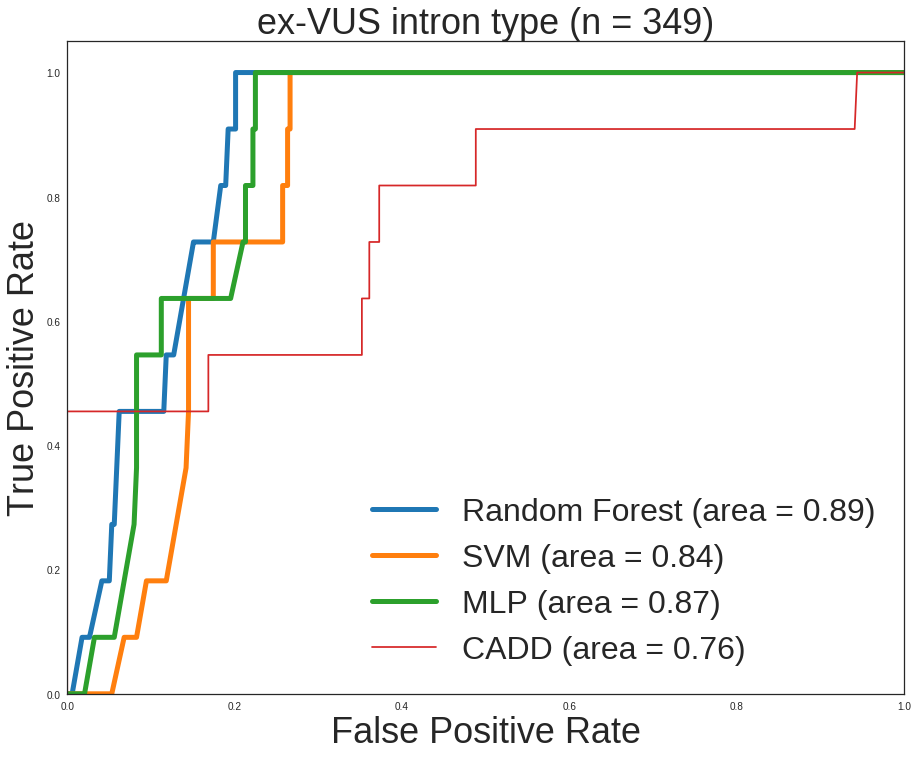

In [80]:
plotValues(vint, X_int,y_int,'intron type','349')

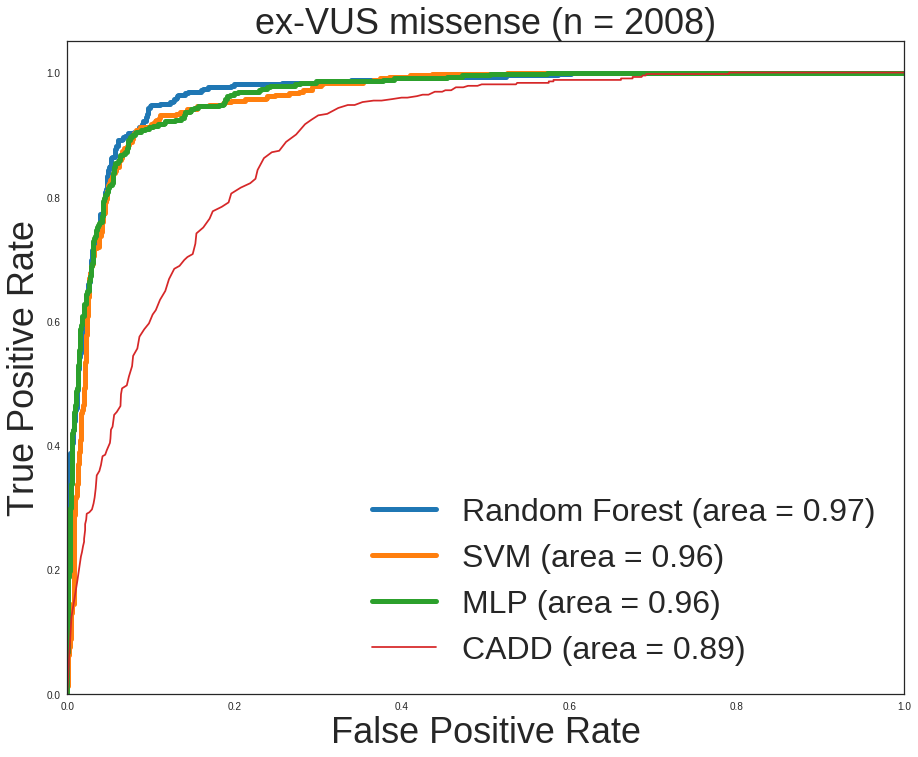

In [81]:
plotValues(miss, X_miss,y_miss,'missense','2008')

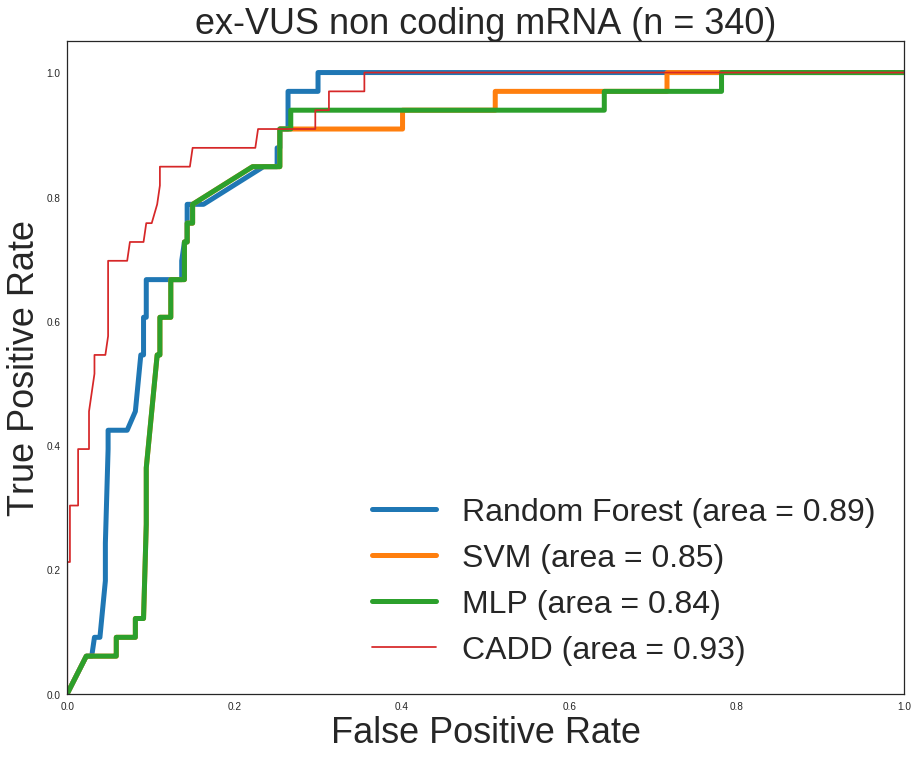

In [82]:
plotValues(nce, X_nce,y_nce,'non coding mRNA','340')

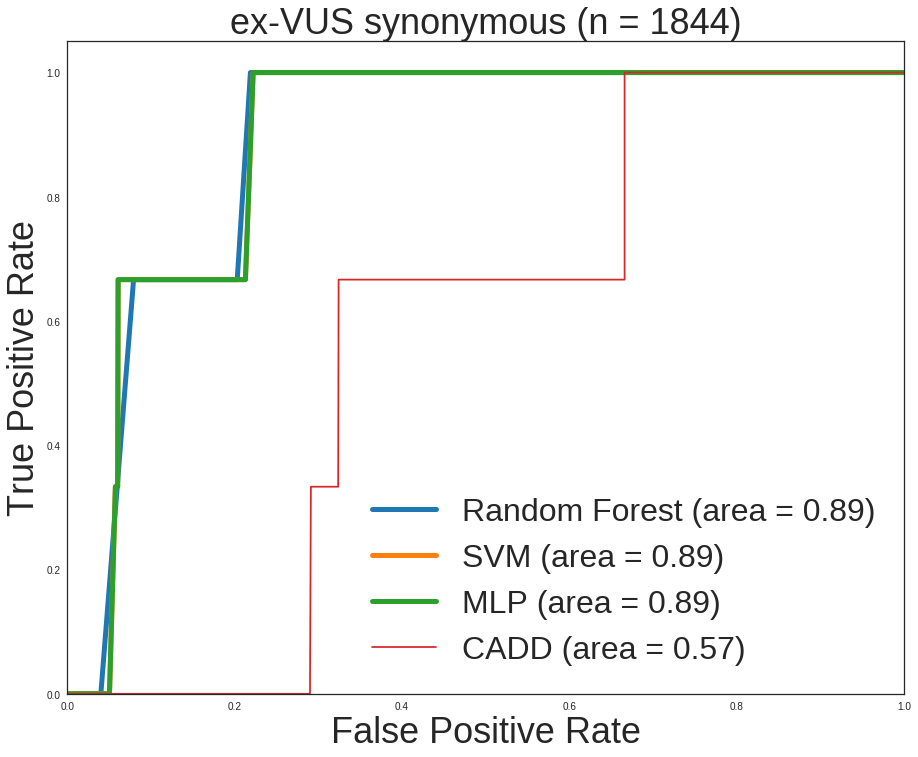

In [83]:
plotValues(syn, X_syn, y_syn, 'synonymous','1844')

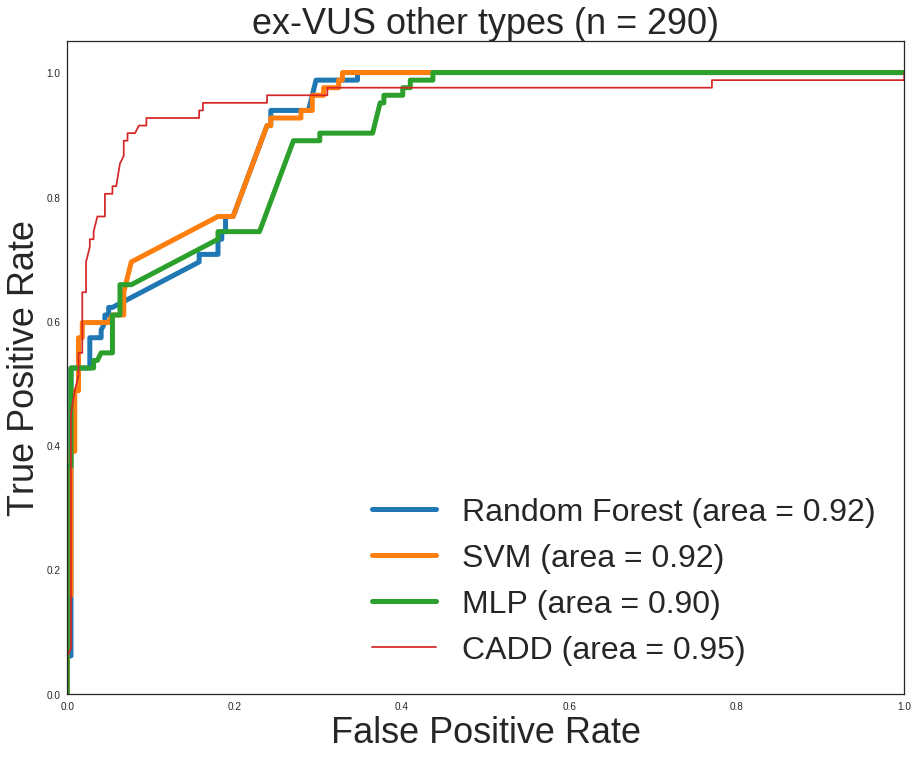

In [84]:
plotValues(oth, X_oth, y_oth, 'other types','290')

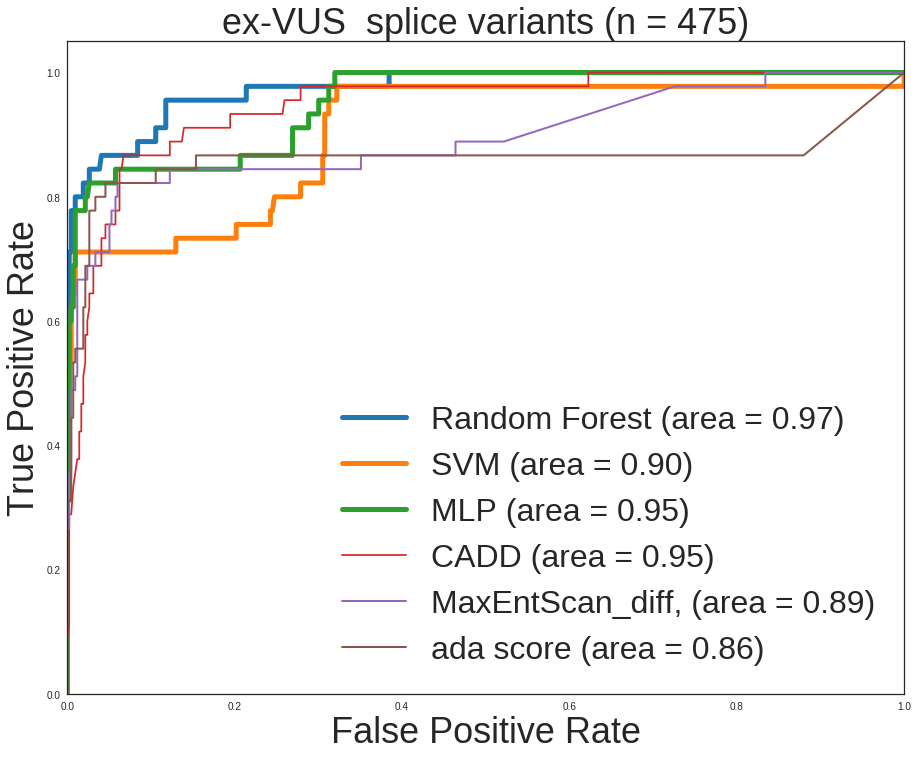

In [78]:
plotValues(spl, X_spl, y_spl, ' splice variants','475')

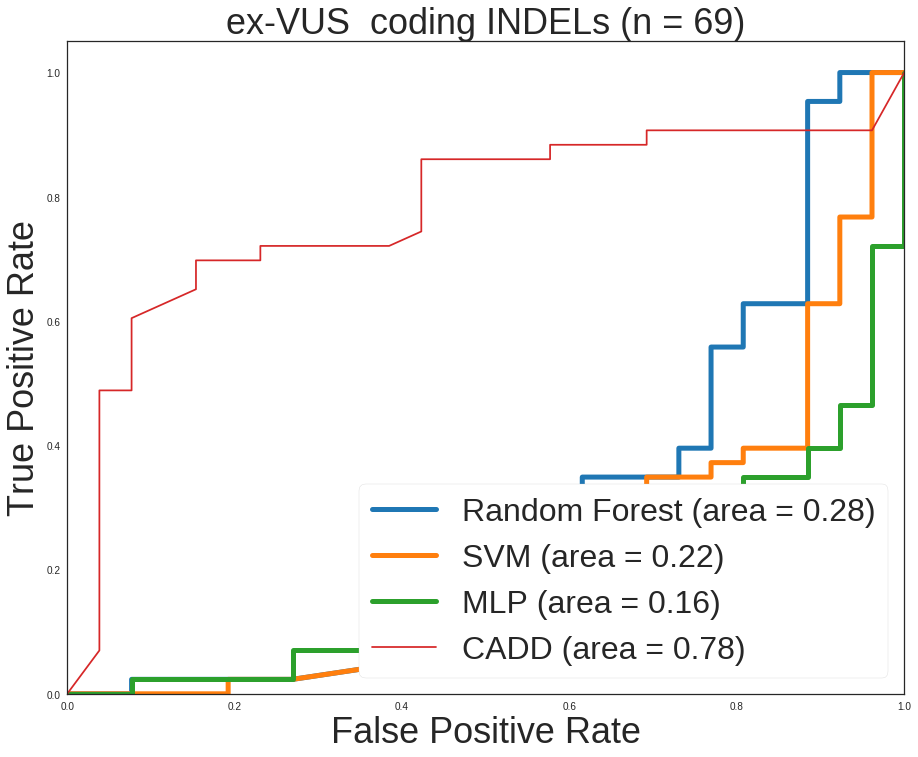

In [107]:
plotValues(indl, X_indl, y_indl, ' coding INDELs', '69')

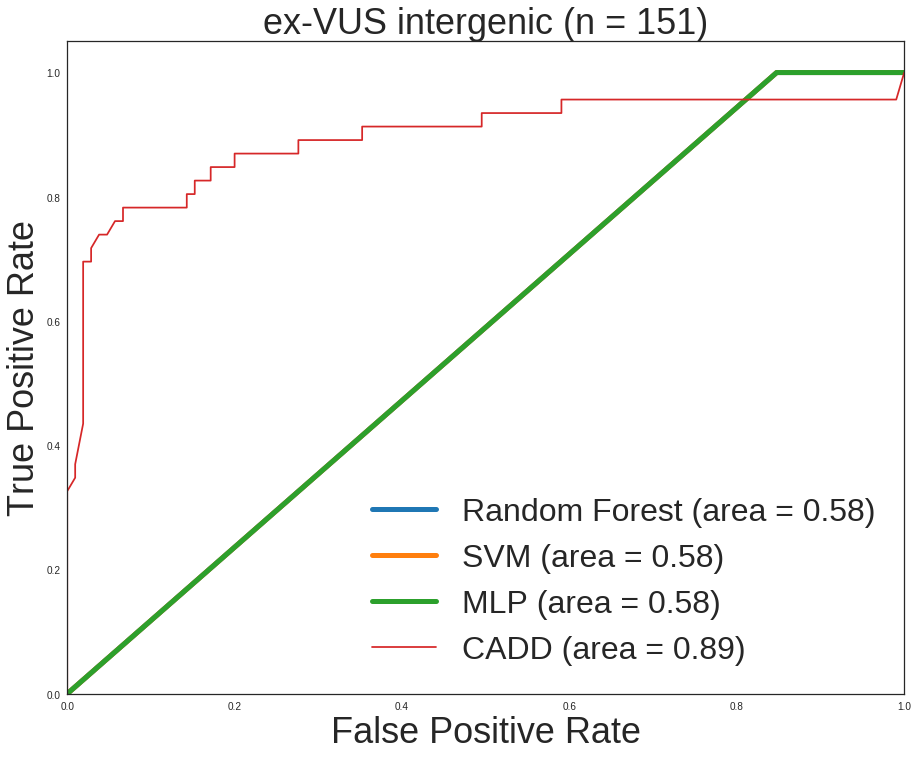

In [110]:
plotValues(ign, X_ign, y_ign, 'intergenic', '151')

# Predicting classification of current VUS

In [99]:
#Function to process current VUS dataset
def processModelVUS(df):
    df['codon_degeneracy'] = df['codon_degeneracy'].str.split(',').str[0]
    df['Consequence'] = df['Consequence'].str.split(',').str[0]
    df = df.replace({'codon_degeneracy':'-'},0)
    df=pd.get_dummies(df,columns=['Consequence'])
    df = df.filter(['ada_score','AF','BLOSUM62','CADD_PHRED','codon_degeneracy','Eigen-pred_coding','GERP++_RS', 
              'integrated_fitCons_score','LoFtool','phyloP100way_vertebrate','SIFT', 'Consequence_5_prime_UTR_variant',
              'Consequence_downstream_gene_variant', 'Consequence_frameshift_variant',
              'Consequence_inframe_deletion', 'Consequence_inframe_insertion',
              'Consequence_intron_variant', 'Consequence_missense_variant',
              'Consequence_non_coding_transcript_exon_variant',
              'Consequence_splice_donor_variant', 'Consequence_splice_region_variant',
              'Consequence_start_lost', 'Consequence_stop_gained',
              'Consequence_synonymous_variant', 'Consequence_upstream_gene_variant'])
    df = df.replace({'ada_score': "-", 'AF': "-", 'CADD_PHRED':"-", 'Eigen-pred_coding': '-',
               'integrated_fitCons_score': '-', 'LoFtool': '-', 'phyloP100way_vertebrate':'-',
               'SIFT': '-'}, -1)
    df = df.replace({'BLOSUM62':"-", 'GERP++_RS':'-'}, 0)
    df = df.replace(".",0)   
    df = df.astype(float)
    scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
    scaler.fit (df)
    return df


In [100]:
#Processing current VUS dataset
vus_model = processModelVUS(vus)
vus_model = completeColumns(vus_model)

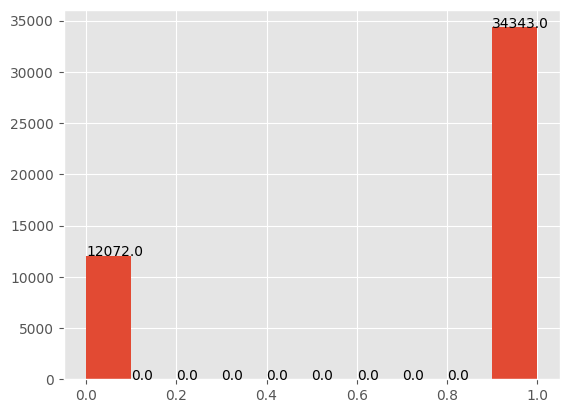

In [647]:
#Predicting classification of current VUS with the RF tool
predict_RF_vus=clf_RF.predict(vus_model)
predict_RF_vus

arr=plt.hist(predict_RF_vus)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

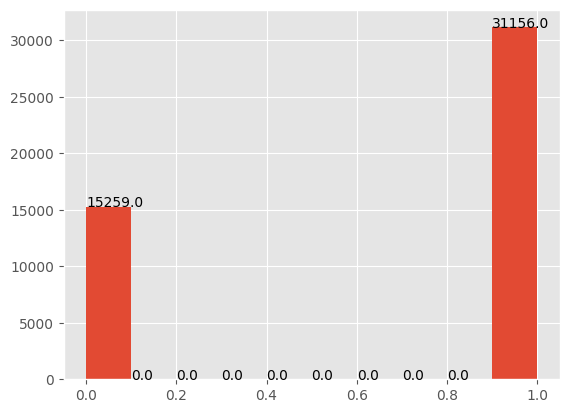

In [648]:
#Predicting classification of current VUS with the SVM tool
predict_svm=svm_modelo.predict(vus_model)
predict_svm

arr=plt.hist(predict_svm)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

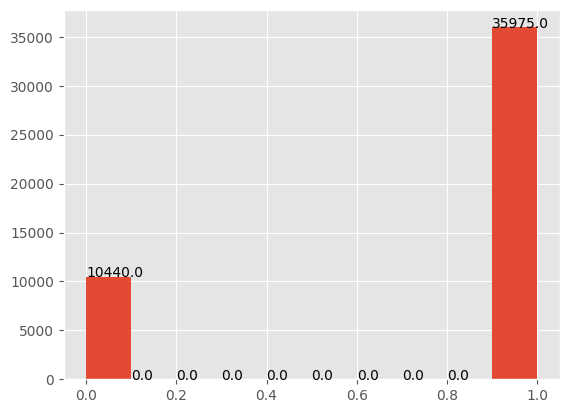

In [652]:
#Predicting classification of current VUS with the MLP tool
predict_red=red_modelo.predict_classes(vus_model)
predict_red
arr=plt.hist(predict_red)
for i in range(10):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))

In [655]:
#Plotting current VUS classification with the RF model
score_RF_vus=clf_RF.predict_proba(vus_model)
plt.figure(figsize=(15,12))
plt.hist(score_RF_vus[:,1],bins=100)

46415

In [110]:
#Plot prediction of the RF model for missense variants from the current VUS set
vus_miss =vus[(vus['REVEL_score']!= "-") & (vus['SIFT']!= "-") & (vus['PolyPhen']!= "-")]
vus_miss = processModelVUS(vus_miss)
vus_miss = completeColumns(vus_miss)
score_RF_pred=clf_RF.predict_proba(vus_miss)
plt.figure(figsize=(15,12))
plt.hist(score_RF_pred)

array([[0.47565846, 0.52434154],
       [0.03081618, 0.96918382],
       [0.30220478, 0.69779522],
       ...,
       [0.45059019, 0.54940981],
       [0.33843565, 0.66156435],
       [0.74212343, 0.25787657]])

(array([ 930.,  774.,  622.,  455.,  406.,  437.,  519.,  583.,  559.,
         468.,  396.,  340.,  248.,  214.,  197.,  172.,  169.,  129.,
         138.,  129.,  113.,  113.,   89.,   81.,   86.,   79.,   81.,
          85.,   73.,   56.,   71.,   69.,   43.,   58.,   69.,   71.,
          57.,   60.,   77.,   53.,   57.,   69.,   50.,   39.,   37.,
          45.,   45.,   42.,   57.,   79.,   18.,   51.,   44.,   51.,
          58.,   54.,   54.,   50.,   59.,   42.,   39.,   54.,   43.,
          43.,   70.,   60.,   48.,   61.,   48.,   63.,   52.,   62.,
          60.,   62.,   67.,   74.,   78.,   76.,   62.,   73.,   88.,
          84.,   85.,   83.,   93.,  107.,  107.,  116.,  122.,  126.,
         151.,  193.,  190.,  242.,  333.,  476., 1006., 7325., 9546.,
        1254.]),
 array([4.09261072e-04, 1.04051485e-02, 2.04010360e-02, 3.03969235e-02,
        4.03928109e-02, 5.03886984e-02, 6.03845859e-02, 7.03804733e-02,
        8.03763608e-02, 9.03722482e-02, 1.00368136e-01, 1.

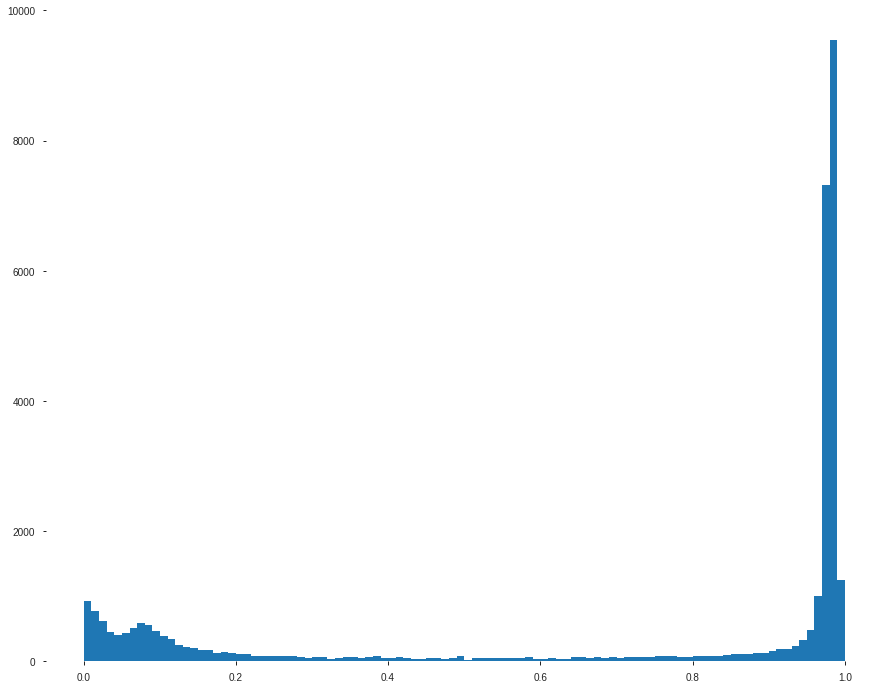

In [114]:
#Plot prediction of the SVM model for missense variants from the current VUS set

score_SVM_vus_miss=svm_modelo.predict_proba(vus_miss)
score_SVM_vus_miss
plt.figure(figsize=(15,12))
plt.hist(score_SVM_vus_miss[:,1],bins=100)

(array([ 558.,  160.,  135.,  152.,  122.,  129.,  145.,  176.,  180.,
         218.,  233.,  235.,  251.,  265.,  252.,  256.,  237.,  195.,
         213.,  190.,  186.,  162.,  164.,  130.,  148.,  138.,  101.,
         106.,   94.,  116.,   99.,  115.,  122.,  111.,   93.,  120.,
         113.,  107.,  118.,  103.,   97.,  102.,   95.,   84.,  100.,
         112.,  100.,  116.,   96.,   96.,  107.,  121.,  116.,  100.,
         123.,  128.,  132.,  112.,  114.,  132.,  125.,  114.,  115.,
         134.,  143.,  138.,  145.,  167.,  149.,  157.,  141.,  160.,
         192.,  177.,  187.,  214.,  225.,  257.,  260.,  246.,  290.,
         320.,  339.,  359.,  414.,  442.,  477.,  501.,  527.,  570.,
         652.,  684.,  810.,  911.,  999., 1105., 1435., 2024., 3216.,
        4840.]),
 array([1.19209290e-07, 9.99987591e-03, 1.99996326e-02, 2.99993902e-02,
        3.99991460e-02, 4.99989018e-02, 5.99986613e-02, 6.99984133e-02,
        7.99981728e-02, 8.99979323e-02, 9.99976844e-02, 1.

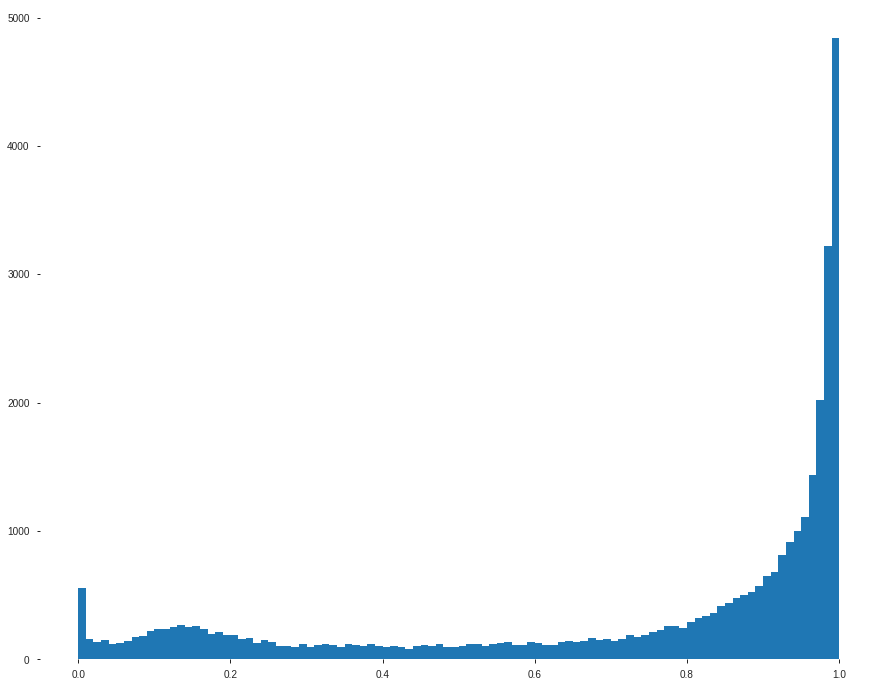

In [116]:
#Plot prediction of the MLP model for missense variants from the current VUS set

score_MLP_vus_miss=red_modelo.predict_proba(vus_miss)
score_MLP_vus_miss
plt.figure(figsize=(15,12))
plt.hist(score_MLP_vus_miss,bins=100)